In [1]:
# originals:
# """
# dcgan: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb#scrollTo=ZBwyU6t2Wf3g
# architecture: https://www.kaggle.com/code/thuylinh225/generate-monet-images-using-dcgan
# naming convention: https://github.com/thashimoto1998/DCGAN/blob/master/dcgan.py
# """

In [2]:
###############################
###         Updates         ###
###############################

#removed text cells
# added WGAN-GP

In [3]:
###############################
###      Mode collapse      ###
###############################

#(done, saved mixed results) train for 100 epochs

#didnt work
#make model less complex
#make model more complex

#(didnt work) kernel size to 3,3 and removed 512 layer from discriminator
# (kinda better) change only kernel size, keep 512 layer

#(nope) kern 2,2

#adding gaussian noise
#(discriminator has it, generator shouldnt) applying dropout

#image transformations
    #augment for more diversity
    # Normalization: Scaling pixel values to a range (e.g., [0, 1]).
    # Resizing: Adjusting the image size if needed.
    # Data Augmentation: variations of the images (e.g., rotations, flips) to improve model robustness.
    # """
    # from PIL import Image
    # import torchvision.transforms as transforms

    # transforms_ = [
    #     transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    #     transforms.RandomCrop((img_height, img_width)),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # ]
    # """

#vanishing gradient
    #Lipschitz constraint
#lack of convergence
#loss function
  # discriminator: binary_crossentropy

#minibatch discrimination

#WGAN
#transfer learning

# """
# https://spotintelligence.com/2023/10/11/mode-collapse-in-gans-explained-how-to-detect-it-practical-solutions/#1_Insufficient_Model_Capacity
# """

In [4]:
# Import TensorFlow and other libraries

import glob
import imageio
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import matplotlib.image as mpimg

from IPython import display

In [5]:
import zipfile
import re
from PIL import Image
import shutil
import matplotlib.animation as animation
from IPython.display import HTML

In [6]:
import pandas as pd
from torchvision.transforms import v2
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

In [7]:
#for WGAN-GP
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [8]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
    print("can't initialize tpu, using default, exception: " + str(e))
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

can't initialize tpu, using default, exception: Please provide a TPU Name to connect to.
Number of replicas: 1


In [9]:
!git clone https://github.com/LyJacky/ImageGeneration.git

Cloning into 'ImageGeneration'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 362 (delta 23), reused 57 (delta 23), pack-reused 305
Receiving objects: 100% (362/362), 28.02 MiB | 11.47 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [10]:
# files = glob.glob(f"/content/ImageGeneration/monet_jpg/*.jpg")
data_path = glob.glob(f"/content/ImageGeneration/monet_jpg")

os.chdir(data_path[0])

data  = []
for file in os.listdir():
    if file.endswith(".jpg"):
        file_path = f"{data_path[0]}/{file}"
        img = mpimg.imread(file_path)
        data.append(img)

In [11]:
print(len(data))
print(data[0].shape)

300
(256, 256, 3)


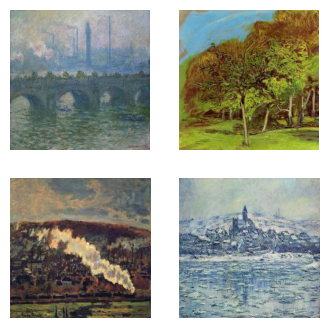

In [12]:
# show some samples

fig = plt.figure(figsize=(4,4))
for i, img in enumerate(data[0:4]):
    plt.subplot(2, 2, i+1)
    plt.imshow(data[i])
    plt.axis('off')
plt.show()

In [13]:
# # normalizing the images to [-1, 1]
# def normalize(image):
#   image = tf.cast(image, tf.float32)
#   image = (image / 127.5) - 1
#   return image

In [14]:
# def augment(image):
#   # image = tf.image.resize(image,[])
#   image = tf.image.random_flip_left_right(image)
#   image = tf.image.random_crop(image)
#   image = tf.image.random_brightness(image)
#   image = tf.image.random_saturation(image)
#   return image

In [15]:
# for val in data:
#   val = normalize(val)

#   # val = tf.image.resize(val, [,])
#   val = tf.image.random_flip_left_right(val)
#   val = tf.image.random_flip_up_down(val)
#   val = tf.image.random_brightness(val, 0.2)
#   # plt.imshow(val)
#   # plt.axis('off')
#   # plt.show()

#   # val = augment(val)


In [16]:
print(len(data))
print(data[0].shape)

300
(256, 256, 3)


In [17]:
# # show some samples
# plt.imshow(data[59])
# plt.axis('off')
# plt.show()

In [18]:
BATCH_SIZE = 100
BUFFER_SIZE = 300

In [19]:
# train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [20]:
# train_dataset

In [21]:
# modified generator

def make_generator_model():

    generator = Sequential(name="Generator")
    generator.add(Dense(16*16*512,
                        input_shape=(100,)))
    generator.add(Reshape((16,16,512)))


    # #layer 5
    # generator.add(Conv2DTranspose(filters=512, kernel_size=(2,2), strides=(2,2), padding='same'))
    # generator.add(LeakyReLU(alpha=0.2))

    # layer 2
    generator.add(Conv2DTranspose(filters=256, kernel_size=(6,6), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))

    #layer 3
    generator.add(Conv2DTranspose(filters=128, kernel_size=(6,6), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))


    #layer 4
    generator.add(Conv2DTranspose(filters=64, kernel_size=(6,6), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))

    #layer 5
    generator.add(Conv2DTranspose(filters=32, kernel_size=(6,6), strides=(2,2), padding='same'))
    generator.add(LeakyReLU(alpha=0.2))

    #output
    generator.add(Conv2DTranspose(3, kernel_size=(6,6), activation='tanh', strides=(1,1), padding='same'))

    return generator

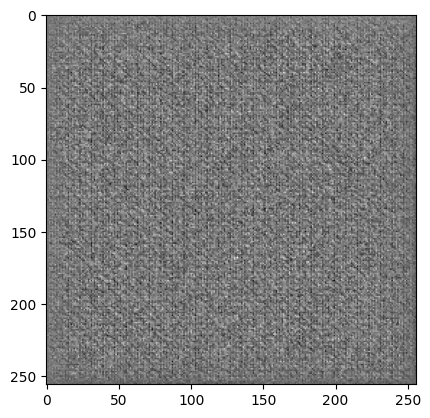

In [22]:
# create noisy image sample
with strategy.scope():
    generator = make_generator_model()
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [23]:
# Discriminator
def make_discriminator_model():

    discriminator = Sequential()

    #layer 1
    discriminator.add(Conv2D(filters=32, kernel_size=(6,6), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
    discriminator.add(LeakyReLU(0.2))

    #layer 2
    discriminator.add(Conv2D(filters=64, kernel_size=(6,6), strides=(2, 2), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    #layer 3
    discriminator.add(Conv2D(filters=128, kernel_size=(6,6), strides=(2, 2), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    #layer 4
    discriminator.add(Conv2D(filters=256, kernel_size=(6,6), strides=(2, 2), padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    # #layer 5
    # discriminator.add(Conv2D(filters=512, kernel_size=(6,6), strides=(2, 2), padding='same'))
    # discriminator.add(BatchNormalization())
    # discriminator.add(LeakyReLU(0.2))

    # #layer 5
    # discriminator.add(Conv2D(filters=1024, kernel_size=(6,6), strides=(2, 2), padding='same'))
    # discriminator.add(BatchNormalization())
    # discriminator.add(LeakyReLU(0.2))

    # Flatten and Output Layers
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(1, activation='sigmoid'))
    # discriminator.add(Dense(1, activation='binary_crossentropy'))

    return discriminator


In [24]:
with strategy.scope():
    discriminator = make_discriminator_model()
    decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5000935]], shape=(1, 1), dtype=float32)


In [25]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [28]:
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [29]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [30]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    # Debug: seed is Seed: tf.Tensor(2D rand num, shape(16,100))

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [31]:

noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [32]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [33]:
#training loop
EPOCHS = 100

In [34]:
# train(train_dataset, EPOCHS)

In [35]:
#gif
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [36]:
# display_image(EPOCHS)

In [37]:
# anim_file = 'dcgan.gif'

# with imageio.get_writer(anim_file, mode='I') as writer:
#   filenames = glob.glob('image*.png')
#   filenames = sorted(filenames)
#   for filename in filenames:
#     image = imageio.imread(filename)
#     writer.append_data(image)
#   image = imageio.imread(filename)
#   writer.append_data(image)

In [38]:
!pip install tensorflow_docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.1 MB/s eta 0:00:00


In [39]:
# import tensorflow_docs.vis.embed as embed
# embed.embed_file(anim_file)

In [40]:
# embed.embed_file(anim_file)

In [41]:
#############################
###    2nd DCGAN Attempt  ###
#############################

In [42]:
generator2 = make_generator_model()
discriminator2 = make_discriminator_model()
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [43]:
class DCGAN_model:
    def __init__(self, noise_dim, EPOCHS, BATCH_SIZE, generator, discriminator, dataset):
        self.noise_dim = noise_dim
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.generator = generator
        #self.discriminator = discriminator2
        self.dataset = dataset

    @tf.function
    def train(self, images):

    # Create random noise vector
        noise = tf.random.normal([images.shape[0], noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # generate images use random noise vector
            generated_images = self.generator(noise, training=True)

            # use discriminator to evaluate the real and fake images
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)
            self.debug(real_output, fake_output)

            # compute generator loss and discriminator loss
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            # Compute gradients
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            # Update optimizers
            generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return (gen_loss + disc_loss) * 0.5

    def debug(self, real_output, fake_output):
        print("\t Discrimator real_output: ", real_output)
        print("\t Discrimator fake_output: ", fake_output)

    @tf.function
    def distributed_train(self, images):
        per_replica_losses = strategy.run(self.train, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)

    def generate_images(self):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_dim])
        predictions = self.generator.predict(noise)
        return predictions

    def generate_and_plot_images(self):
        image = self.generate_images()
        gen_imgs = 0.5 * image + 0.5
        fig = plt.figure(figsize=(10, 10))
        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(gen_imgs[i, :, :, :])
            plt.axis('off')
        plt.show()

    def train_loop(self):
        e_ls = []
        mean_ls = []
        for epoch in range(self.EPOCHS):
            start = time.time()

            total_loss = 0.0
            num_batches = 0

            for image_batch in self.dataset:
                loss = self.distributed_train(image_batch)
                total_loss += tf.reduce_mean(loss)
                num_batches += 1
            mean_loss = total_loss / num_batches

            if (epoch+1) % 20 == 0:
                print ('Time for epoch {} is {} sec, mean loss is {}'.format(epoch + 1, time.time()-start, mean_loss))
                self.generate_and_plot_images()

                e_ls.append(epoch+1)
                mean_ls.append(mean_loss)
        print("\nMean Loss for every 20 epochs: \n")
        table = pd.DataFrame({"Epoch": e_ls, "Mean Loss": np.array(mean_ls)})
        return table

In [44]:
#training loop
EPOCHS = 100

In [45]:
# # train, visualize and print out the result for DCGAN model
# gan1 = DCGAN_model(noise_dim, EPOCHS, BATCH_SIZE, generator2, discriminator2, train_dataset)
# res1 = gan1.train_loop()
# res1

In [46]:
# res1

In [47]:
# gan1.generate_and_plot_images()

In [48]:
#############################
###    WGAN-GP Attempt    ###
#############################

In [49]:
"""
dataset = datasets.

- change cpu in gradient_penalty?
- different learning rates for disc, gen
- image size???
"""

'\ndataset = datasets.\n\n- change cpu in gradient_penalty?\n- different learning rates for disc, gen\n- image size???\n'

In [50]:
def gradient_penalty(disc, real, fake, device="cpu"):
  BATCH_SIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # calcuate discriminator scores
  mixed_scores = disc(interpolated_images)

  gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient - 1) ** 2)
  return gradient_penalty


In [51]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(channels_img, features_d, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(0.2),

        #_block(in_channels, out_channels, kernel_size, stride, padding)
        self._block(features_d, features_d * 2, 4, 2, 1),
        self._block(features_d * 2, features_d * 4, 4, 2, 1),
        self._block(features_d * 4, features_d * 8, 4, 2, 1),

        # output is 4x4 (Conv2d turns into 1x1)
        nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        # nn.BatchNorm2d(out_channels),
        nn.InstanceNorm2d(out_channels, affine=True),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)

In [52]:
class Generator(nn.Module):
  def __init__(self, channels_noise, channels_img, features_g):
    super(Generator, self).__init__()
    self.net = nn.Sequential(
        self._block(channels_noise, features_g * 16, 4, 1, 0),
        self._block(features_g * 16, features_g * 8, 4, 2, 1),
        self._block(features_g * 8, features_g * 4, 4, 2, 1),
        self._block(features_g * 4, features_g * 2, 4, 2, 1),
        nn.ConvTranspose2d(
            features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
        ),
        nn.Tanh(),
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


In [53]:
import torchvision.transforms as transforms


In [54]:
# hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# LEARNING_RATE = 1e-4
DISCRIMINATOR_LEARNING_RATE = 1e-4
GENERATOR_LEARNING_RATE = 5e-5
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
DISC_ITERATIONS = 5
LAMBDA_GP = 10

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

cuda


In [55]:
# checkpoints

def save_checkpoints(state, filename="monet_wgan_gp.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checpoint(checkpoint, gen, disc):
  print("=> Loading checkpoint")
  gen.load_state_dict(checkpoint['gen'])   # generator
  disc.load_state_dict(checkpoint['disc']) # discriminator

In [56]:
def wgan_generate_images():
    noise = tf.random.normal([BATCH_SIZE, Z_DIM])
    # predictions = gen.predict(noise)
    fake = gen(noise)
    return fake

def wgan_generate_and_plot_images():
    image = wgan_generate_images()
    gen_imgs = 0.5 * image + 0.5
    fig = plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_imgs[i, :, :, :])
        plt.axis('off')
    plt.show()

In [57]:
# root=/content/ cannot contain hidden foldera
!rm -r ../ImageGeneration/
!rm -r ../.ipynb_checkpoints/
!rm -r ../.git/

rm: cannot remove '../.ipynb_checkpoints/': No such file or directory


In [58]:
# !ls -a

In [59]:
# make sure to not have image_at_epoch_0010.jpg in the folder

dataset = datasets.ImageFolder(root="/content/ImageGeneration/", transform=transforms) #this line takes long
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

# opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
# opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_gen = optim.Adam(gen.parameters(), lr=GENERATOR_LEARNING_RATE, betas=(0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=DISCRIMINATOR_LEARNING_RATE, betas=(0.0, 0.9))

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
# writer_real = SummaryWriter(f"logs/real")
# writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [60]:
# print(len(dataset))
# print(len(dataset[0]))
# print((dataset[0][0]), "\n")
# print((dataset[0][0][0]), "\n")
# print((dataset[0][0][0][0]), "\n")

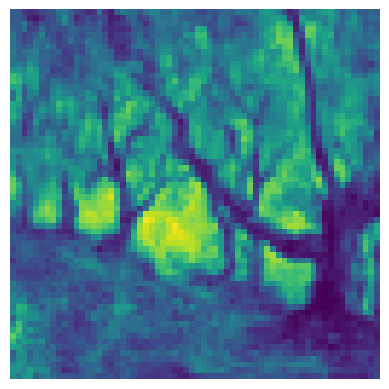

In [61]:
# show some samples
plt.imshow(dataset[1][0][2])
plt.axis('off')
plt.show()

In [62]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [71]:
EPOCHS = 50

In [72]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

EPOCH [0/50] Batch 0/10 Loss D: -14341.0469, loss G: 9421.9287


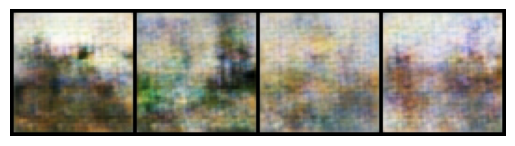

EPOCH [3/50] Batch 0/10 Loss D: -13096.2070, loss G: 9062.8896


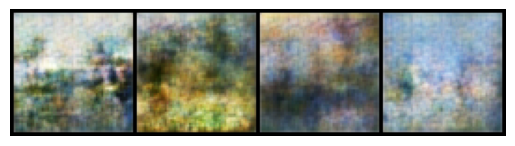

EPOCH [6/50] Batch 0/10 Loss D: -15414.3916, loss G: 9791.4775


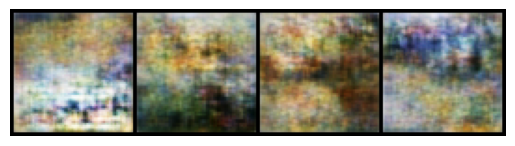

EPOCH [9/50] Batch 0/10 Loss D: -15100.9336, loss G: 10074.4219


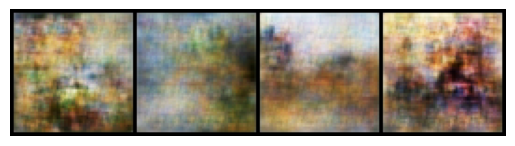

EPOCH [12/50] Batch 0/10 Loss D: -15119.7744, loss G: 10402.4834


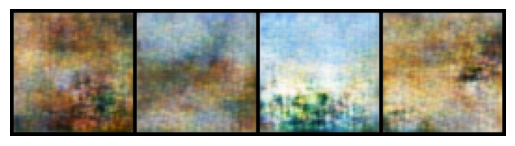

EPOCH [15/50] Batch 0/10 Loss D: -14535.9746, loss G: 10702.8008


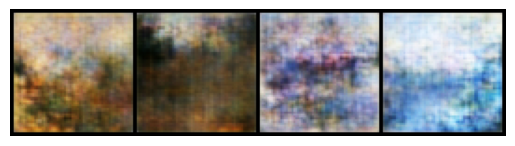

EPOCH [18/50] Batch 0/10 Loss D: -14555.1855, loss G: 10035.7793


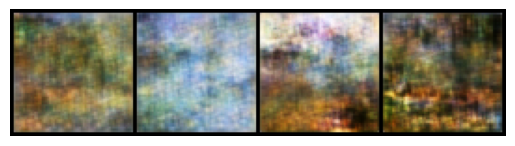

EPOCH [21/50] Batch 0/10 Loss D: -15954.1836, loss G: 11475.0127


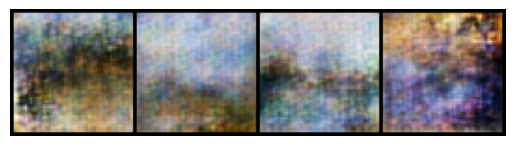

EPOCH [24/50] Batch 0/10 Loss D: -16500.1523, loss G: 10261.8242


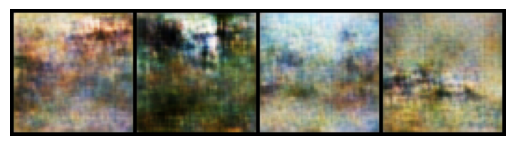

EPOCH [27/50] Batch 0/10 Loss D: -14436.3945, loss G: 11064.5098


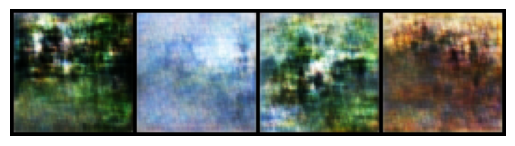

EPOCH [30/50] Batch 0/10 Loss D: -14296.4912, loss G: 11941.1133


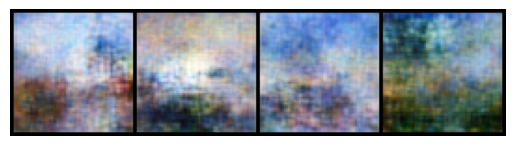

EPOCH [33/50] Batch 0/10 Loss D: -16144.3691, loss G: 11414.7627


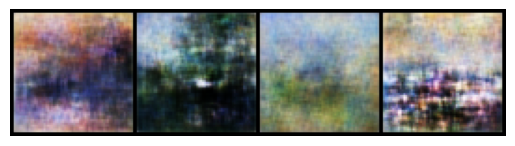

EPOCH [36/50] Batch 0/10 Loss D: -17641.1074, loss G: 11537.1387


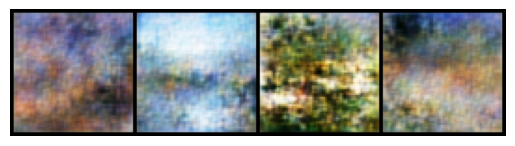

EPOCH [39/50] Batch 0/10 Loss D: -15325.8711, loss G: 11657.9746


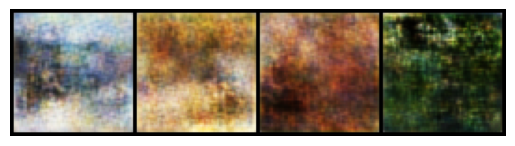

EPOCH [42/50] Batch 0/10 Loss D: -18070.1113, loss G: 12437.9434


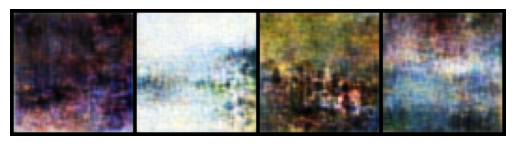

EPOCH [45/50] Batch 0/10 Loss D: -17433.7500, loss G: 10453.6758


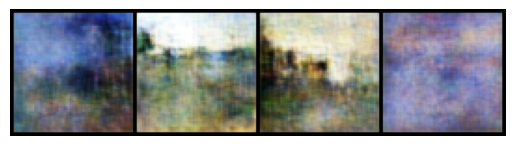

EPOCH [48/50] Batch 0/10 Loss D: -18736.2695, loss G: 11772.1367


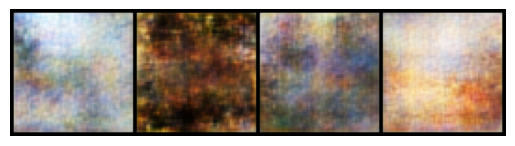

In [74]:
for epoch in range(EPOCHS):
  for batch_idx, (real_img, _) in enumerate(dataloader):
    real = real_img.to(device)
    if len(real) < 32: # sometimes had tensor of size 12
        break

    for _ in range(DISC_ITERATIONS):

      noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
      fake = gen(noise)
      disc_real = disc(real).reshape(-1)
      disc_fake = disc(fake).reshape(-1)
      gp = gradient_penalty(disc, real, fake, device=device)
      loss_disc = (
          -(torch.mean(disc_real) - torch.mean(disc_fake)) + LAMBDA_GP*gp
      )
      disc.zero_grad()
      loss_disc.backward(retain_graph=True)
      opt_disc.step()

    output = disc(fake).reshape(-1)
    loss_gen = -torch.mean(output)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    if epoch % 3 == 0 and batch_idx == 0:
      print(
          f"EPOCH [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
      )

      # fake = gen(fixed_noise)
      image_to_display = fake.cpu().detach().numpy()
      # # image_to_display = image_to_display.transpose(0, 1, 2, 3)
      # plt.imshow(image_to_display[0][0])
      # plt.axis('off')
      # plt.show()

      with torch.no_grad():
          fake = gen(noise)
          img_grid_fake = torchvision.utils.make_grid(
            fake[:4], normalize=True
          )
          plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
          plt.axis('off')
          plt.show()
      step += 1

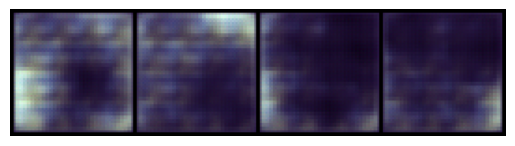

In [66]:
with torch.no_grad():
    noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
    fake = gen(noise)
    img_grid_fake = torchvision.utils.make_grid(
      fake[:4], normalize=True
    )

# image_to_display = fake.cpu().detach().numpy()
# image_to_display = image_to_display.transpose(0, 1, 2, 3)
plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()


In [67]:
      #  device='cuda:0') len(real) 12

# device='cuda:0', grad_fn=<TanhBackward0>) len(fake):  32